# Test Samplers by Hopping on a Graph

Let's test samplers by checking whether they run a model the same way. The model is that a particle hops around a graph, from graph node to graph node. Each hop is determined by a continuous univariate distribution. We'll let a particle hop around and then ask, at the end, how much time it spent on each node.

In [2]:
using Pkg
Pkg.activate(".")
using CompetingClocks
using LinearAlgebra
using Plots
using StatsPlots
using Revise

  Activating project at `~/dev/CompetingClocks/examples`


In [3]:
include("../test/graph_occupancy.jl")

sample_run_graph_occupancy (generic function with 2 methods)

Make the model. This model is made by a random number generator, where the random number generator determines which nodes are connected (so you can hop from one to the other) and which distribution determines the speed of each hop.

Our plan is to use bootstrapping to estimate how much variance we should expect with different samplers. We'll start with a sampler we trust and run this 100 times. Then assume the average result is our expected value. We look at the odds ratio of those 100 draws to see how big they can get. Then, when we want to test another sampler, run it 10 or 100 times and look to see if its odds ratios are mostly within the range that we've seen already.

In [4]:
Threads.nthreads()

24

In [5]:
model_rng = Xoshiro(3498217)  # Random number generator.
features = Dict{String,Bool}(
    "weibull"=>false, "gamma"=>false, "past"=>false, "future"=>false,
    "memory"=>false)
singleton_groc = GraphOccupancy(features, model_rng)
length(singleton_groc)

8

In [6]:
function generate_samples(singleton_groc, singleton_sampler, trial_cnt)
    occupancy = zeros(Float64, (length(singleton_groc), trial_cnt))
    rng = Xoshiro(24370233)
    Threads.@threads for trial_idx in 1:trial_cnt
        # Deepcopy the model because it contains state from each time it has run.
        groc = deepcopy(singleton_groc)
        sampler = deepcopy(singleton_sampler)
        occ, observations = run_graph_occupancy(groc, 1e6, sampler, rng)
        occupancy[:, trial_idx] .= occ
    end
    occupancy
end

generate_samples (generic function with 1 method)

In [7]:
# sampler = FirstReaction{keyspace(GraphOccupancy)}()
sampler = FirstToFire{keyspace(GraphOccupancy)}()
trial_cnt = 100
occupancy = generate_samples(singleton_groc, sampler, trial_cnt)

8×100 Matrix{Float64}:
      1.4288e5        1.42884e5  1.42114e5  …  142325.0        1.42539e5
 159915.0             1.59626e5  1.59709e5          1.59849e5  1.59399e5
      1.26278e5  127622.0        1.26762e5          1.27929e5  1.27342e5
      0.0             0.0        0.0                0.0        0.0
      1.26599e5       1.265e5    1.26851e5          1.26619e5  1.26672e5
      1.3696e5        1.36329e5  1.36819e5  …       1.36383e5  1.36808e5
      1.42558e5       1.42389e5  1.42734e5     142173.0        1.42075e5
      1.64811e5       1.6465e5   1.65012e5          1.6472e5   1.65165e5

That zero dwell time is pesky. It means there was a component of the graph that wasn't connected, which is fine, but it will throw off the stats. We're going to see how likely each draw is using https://en.wikipedia.org/wiki/Multinomial_test. Here, we're treating particle-is-on-the-node as a draw for that node as the outcome. It's not right, but we can use this for a bootstrap. The natural logarithm of the likelihood ratio between the probabilities of the two runs is
$$
    -2\sum_{i=1}^{k} x_i \ln\left(\frac{\pi_i}{p_i}\right)
$$
Here, we assign the expected value, $\pi_i$ from the mean of many runs. $x_i$ is the time for the particle on a particular node, and $p_i$ is the fraction of time on one node, normalized by time on all nodes.

In [8]:
function occupancy_likelihood_ratio(occupancy, mle)
    # Sometimes a graph node is disconnected, so remove those.
    keep_row = [sum(occupancy[check_idx,:]) > 0 for check_idx in 1:size(occupancy, 1)]
    occupancy = occupancy[keep_row, :]
    category_cnt, trial_cnt = size(occupancy)
    odds_ratio = zeros(Float64, trial_cnt)
    for trial_idx in 1:trial_cnt
        relative_occupancy = occupancy[:, trial_idx] / sum(occupancy[:, trial_idx])
        log_odds = 0.0
        for node_idx in 1:category_cnt
            log_odds += occupancy[node_idx, trial_idx] * log(mle[node_idx] / relative_occupancy[node_idx])
        end
        odds_ratio[trial_idx] = -2 * log_odds
    end
    return odds_ratio
end

function maximum_likelihood(occupancy)
    # Sometimes a graph node is disconnected, so remove those.
    keep_row = [sum(occupancy[check_idx,:]) > 0 for check_idx in 1:size(occupancy, 1)]
    occupancy = occupancy[keep_row, :]
    category_cnt = size(occupancy, 1)
    trial_cnt = size(occupancy, 2)
    expected_occupancy = sum(occupancy; dims=2) / trial_cnt
    mle = expected_occupancy / sum(expected_occupancy)
end

maximum_likelihood (generic function with 1 method)

This set of 100 numbers is 100 odds ratios. If we do a bunch of draws from another sampler, we expect their odds ratios to be mostly in this range.

In [9]:
mle = maximum_likelihood(occupancy)
odds_ratios = occupancy_likelihood_ratio(occupancy, mle)
sort!(odds_ratios)

100-element Vector{Float64}:
   0.3907189945959715
   0.5201943806818576
   0.625171177895254
   0.6253998516927481
   0.7028588845286095
   1.0751081077071944
   1.2879539474881767
   1.4142008268183304
   1.4324751573565209
   1.4729401031464704
   ⋮
  18.30270353131482
  19.243630426334732
  19.73558837672863
  20.928766306535977
  25.586088615255107
 232.1920479878372
 300.8371113460353
 312.6121599973576
 320.61356181077554

Just checking that a perfect odds ratio is basically zero.

In [10]:
perfect = zeros(length(mle), 2)
perfect[:,1] .= mle * 1e6
perfect[:,2] .= mle * 1e6
occupancy_likelihood_ratio(perfect, mle)

2-element Vector{Float64}:
 -2.538419875464029e-10
 -2.538419875464029e-10

Now we're ready to evaluate the FirstToFire sampler. This should behave identically to the FirstReaction sampler, especially considering that this model disables all enabled nodes at every step.

In [11]:
# sampler = FirstToFire{keyspace(GraphOccupancy)}()
sampler = FirstReaction{keyspace(GraphOccupancy)}()
trial_cnt = 10
first_to_fire = generate_samples(singleton_groc, sampler, trial_cnt)

8×10 Matrix{Float64}:
      1.41576e5       1.41387e5       1.41177e5  …       1.41486e5  1.41204e5
      1.58107e5       1.58886e5       1.58517e5          1.58334e5  1.58523e5
      1.31875e5       1.3138e5   132054.0                1.31882e5  1.31867e5
      0.0             0.0             0.0                0.0        0.0
 127559.0             1.26871e5       1.27066e5          1.2713e5   1.27026e5
      1.36656e5       1.36896e5       1.3662e5   …       1.36509e5  1.36967e5
      1.41469e5       1.4167e5        1.41826e5     141521.0        1.41776e5
      1.62757e5  162910.0             1.6274e5           1.63137e5  1.62636e5

Well, these odds don't look like they are in the right range.

In [12]:
ftf_odds_ratio = occupancy_likelihood_ratio(first_to_fire, mle)
sort!(ftf_odds_ratio)

10-element Vector{Float64}:
 171.1807075316824
 180.17026727930124
 180.4123010946496
 204.67988763567064
 219.01948865904933
 228.32391664819988
 235.20382545811663
 239.95617188287997
 250.31063916207404
 259.0211724964465

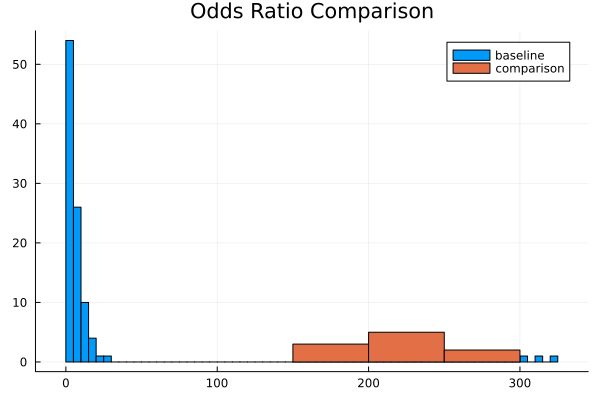

In [13]:
histogram(odds_ratios, label="baseline")
title!("Odds Ratio Comparison")
histogram!(ftf_odds_ratio, label="comparison")

Let's look in more depth at a single run with this sampler. We were using the total duration spent on each node during $10^6$ time units in order to evaluate if the sampler is working well. We can dig in by looking at another output of the model. The "observations" are a dictionary with an entry for each transition that tells us the total number of times that transition fired. If we group them by source node, that tells us how the particle left each node. If one type of transition wasn't firing properly due to some code error, it should show up as a bias in how the particle leaves the node.

In [ ]:
rng = Xoshiro(2431243)
groc_ftf = deepcopy(singleton_groc)
sampler_ftf = FirstToFire{keyspace(GraphOccupancy)}()
occupancy_ftf, observations_ftf = run_graph_occupancy(groc_ftf, 1e7, sampler_ftf, rng)
groc_fr = deepcopy(singleton_groc)
sampler_fr = FirstReaction{keyspace(GraphOccupancy)}()
occupancy_fr, observations_fr = run_graph_occupancy(groc_fr, 1e7, sampler_fr, rng)


Just looking at the raw occupancies shows that the total dwell time on node 4 could be off. Because this is a particle on a graph, you can see dwell time increase on one node because of a problem on a neighboring node that dumps out to it. That is, this high dwell time doesn't mean there is a problem with the distributions on that node. We'll have to dig a little deeper.

In [ ]:
hcat(occupancy_fr, occupancy_ftf)

In [ ]:
sort(collect(observations_fr), by = a -> a[1][1])

In [ ]:
sort(collect(observations_ftf), by = a -> a[1][1])

Here, I'm trying to summarize, node-by-node, the probability of leaving that node for a neighbor. So, given that you are at node 5, you can go to nodes 4, 6, 7, 2, 8, or 1. Let's take every transitition from 5 to each of those, normalize by the each direction, and turn it into a probability for P[4|5], P[6|5], and so on. Do this for both the FirstReaction and FirstToFire and compare the tuples.

In [ ]:
ways_out = Array{Dict{Int,Tuple{Float64,Float64}},1}()
node_cnt = nv(singleton_groc.g)
for init_ways in 1:node_cnt
    comparator = Dict{Int,Tuple{Float64,Float64}}()
    totals = zeros(Int64, 0)
    for obs in [observations_fr, observations_ftf]
        total_calls = 0
        for jump_to in neighbors(singleton_groc.g, init_ways)
            total_calls += obs[(init_ways, jump_to)].call_cnt
        end
        push!(totals, total_calls)
    end
    for way_out in neighbors(singleton_groc.g, init_ways)
        comparator[way_out] = (observations_fr[(init_ways, way_out)].call_cnt / totals[1],
            observations_ftf[(init_ways, way_out)].call_cnt / totals[2])
    end
    push!(ways_out, comparator)
end
ways_out

Actually, that node 4 only has a single path to another node. Let's see what the transition away is. It does have a relative_enabling_time, meaning it always claims to have a te 0.9 time units in the past.

In [ ]:
singleton_groc.transition[(4,5)]

And in the other direction there is also an offset, this time into the future. This one is more suspicious, actually.

In [ ]:
singleton_groc.transition[(5,4)] 

In [ ]:
for dest in [1,2,4,6,7,8]
    print("fr  ")
    println(observations_fr[(5,dest)])
    print("ftf ")
    println(observations_ftf[(5,dest)])
end

In [ ]:
observations_ftf[(5,4)]